# Communication Delay Model

Suppose that we have a delay model where the probability of sending the data gets higher over time. We can achieve this by using CDF as the probability fcn. The CDF can be obtained from half normal distribution, exponential distribtuion, etc.

## Load Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import halfnorm, expon
import math

## Create message transmission simulation

In [23]:
def probability_distribution(time_elapsed):
    max_time = 10.0
    
    # create a constant prob, prob is 1 for 10 (assume 10s is the latest)
    result = np.copy(time_elapsed)
    result[result < max_time] = 0.30
    result[result == max_time] = 1
    
    return result

Text(0, 0.5, 'Update Probability [%]')

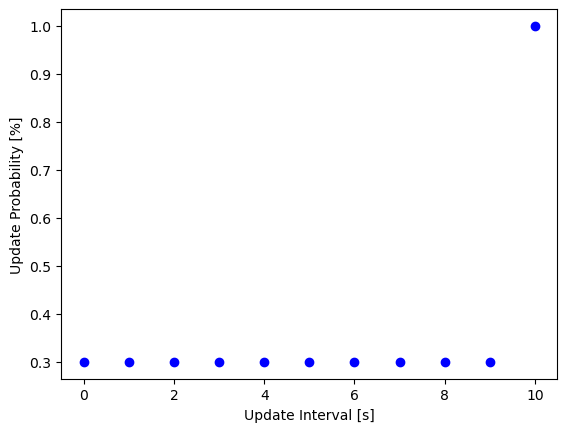

In [24]:
x = np.arange(0.0, 10.1, 1.0)
prob = probability_distribution(x)

plt.scatter(x, prob, color = 'b')
plt.xlabel('Update Interval [s]')
plt.ylabel('Update Probability [%]')

In [25]:
#create 1000 aircrafts and initiate the lastupdate
nb_aircraft = 10
lastupdate = np.zeros(nb_aircraft)

# set update interval as 1s
update_interval = 1

# initialize time and define total simtime as 10.000s
simt = 0
total_simtime = 10000

# initialize time elapsed log
time_elapsed_total = []

# initialize counter
counts_sent = {}

while simt <= total_simtime:
    simt += update_interval

    # time elapsed is the difference between the current time and the lastupdate
    time_elapsed = simt - lastupdate
    
    # get the update probability from the CDF
    update_prob = probability_distribution(time_elapsed)

    # select the updated index based on a randomized value and the update probability
    cond = np.random.random(size = nb_aircraft) < update_prob
    up = np.where(cond)

    # count the value of each sent data
    for value in time_elapsed[up]:
        if value in counts_sent:
            counts_sent[value] += 1
        else:
            counts_sent[value] = 1

    # update the lastupdate of each sent data and log the time elapsed for sent data
    lastupdate[up] = simt
    time_elapsed_total.extend(time_elapsed[up])

## Analyze the data

In [26]:
# calculate all the occurrence

total_sent = sum(counts_sent.values())

counts_percentage_sent = {key: value / total_sent for key, value in counts_sent.items()}
counts_percentage_sent = dict(sorted(counts_percentage_sent.items()))

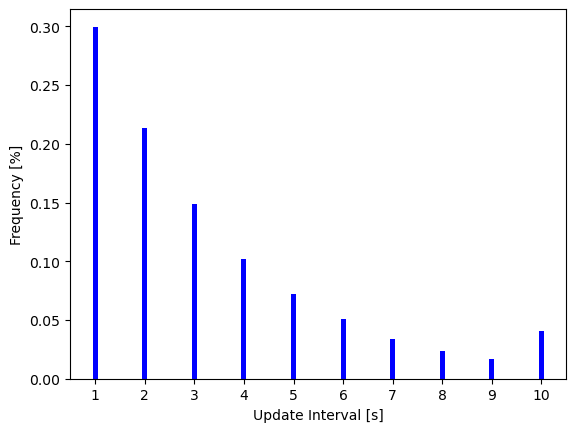

In [27]:
plt.figure(1)

plt.bar(counts_percentage_sent.keys(), counts_percentage_sent.values(), color = 'b', width = 0.1);
plt.xlabel("Update Interval [s]");
plt.ylabel("Frequency [%]");
plt.xticks(np.arange(min(counts_percentage_sent.keys()), max(counts_percentage_sent.keys())+1, 1.0));

{1.0: 0.29963922174977453, 2.0: 0.5126594511016622, 3.0: 0.6612549929132845, 4.0: 0.763335910320835, 5.0: 0.8350405875531505, 6.0: 0.8858394536786498, 7.0: 0.9194691405746683, 8.0: 0.9426620280891639, 9.0: 0.9593802345058627, 10.0: 1.0}


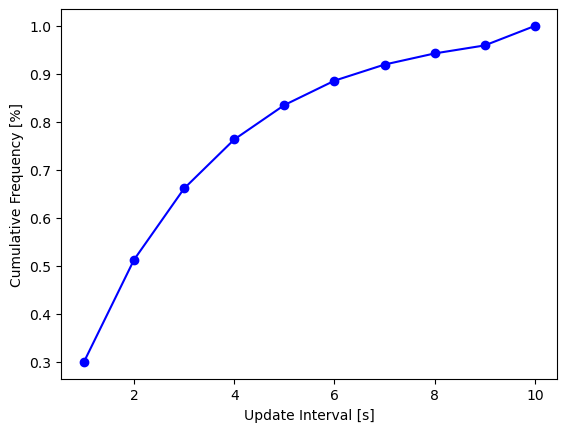

In [28]:
cumulative = {}

cum = 0

for key in counts_percentage_sent.keys():
    cum += counts_percentage_sent[key]
    cumulative[key] = cum
    
plt.plot(cumulative.keys(), cumulative.values(), 'bo-')
plt.xlabel("Update Interval [s]");
plt.ylabel("Cumulative Frequency [%]");
# plt.xticks(np.arange(min(counts

print(cumulative)

## Markov Chain analysis

Note that the probability of the data being sent (and reset to *simt*) for time_elapsed *t* only depends on the current time_elapsed. Thus, we can model the delay as a Markov Chain. More details are written in my personal notebook.

In [29]:
# let's take the states from the previous simulations
states = list(counts_percentage_sent.keys())
n = len(states)
P = np.zeros((n, n))

# create the transition matrix
for i in range(len(states) - 1):
    P[i][0] = probability_distribution(states[i])
    P[i][i+1] = 1 - P[i][0]
        
P[n-1][0] = 1

In [30]:
pi = np.array([0 for x in states])
pi[0] = 1

# to get the equilibrium states, instead of solving for pi*A = pi,
# we can do the operation for several times
nb_of_calc = 100

for i in range(nb_of_calc):
    pi = np.dot(pi, P)
    
# the expected occurrence of each sent data is the normalized probability of each state
expected_occurrence = pi * P[:, 0]/sum(pi * P[:, 0])
print(pi)
print(expected_occurrence)

[0.30872059 0.21610441 0.15127309 0.10589116 0.07412381 0.05188667
 0.03632067 0.02542447 0.01779713 0.01245799]
[0.3        0.21       0.147      0.1029     0.07203    0.050421
 0.0352947  0.02470629 0.0172944  0.04035361]


## Comparisons

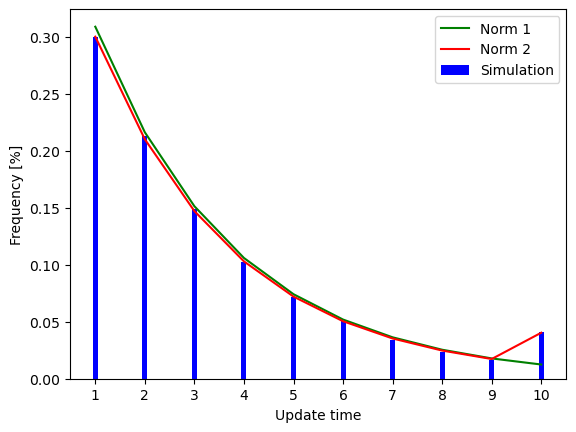

In [31]:
plt.figure(1)

plt.plot(states, pi/sum(pi), color = 'g', label = "Norm 1")
plt.plot(states, expected_occurrence, color = 'r', label = "Norm 2")
plt.bar(counts_percentage_sent.keys(), counts_percentage_sent.values(), label = "Simulation", color = 'b', width = 0.1);
plt.xlabel("Update time");
plt.ylabel("Frequency [%]");
plt.legend();
plt.xticks(np.arange(min(counts_percentage_sent.keys()), max(counts_percentage_sent.keys())+1, 1.0));

In [36]:
pi = np.array([0 for x in states])
pi[0] = 1

PI = np.ones((len(states), len(states)))

# to get the equilibrium states, instead of solving for pi*A = pi,
# we can do the operation for several times
nb_of_calc = 100

for i in range(nb_of_calc):
    pi = np.dot(pi, P)
    PI = np.dot(PI, P)
    
# the expected occurrence of each sent data is the normalized probability of each state
expected_occurrence = pi * P[:, 0]/sum(pi * P[:, 0])
print(pi)
print(PI)
print(expected_occurrence)

[0.30872059 0.21610441 0.15127309 0.10589116 0.07412381 0.05188667
 0.03632067 0.02542447 0.01779713 0.01245799]
[[3.08720593 2.16104415 1.5127309  1.05891163 0.74123814 0.5188667
  0.36320669 0.25424468 0.17797128 0.12457989]
 [3.08720593 2.16104415 1.5127309  1.05891163 0.74123814 0.5188667
  0.36320669 0.25424468 0.17797128 0.12457989]
 [3.08720593 2.16104415 1.5127309  1.05891163 0.74123814 0.5188667
  0.36320669 0.25424468 0.17797128 0.12457989]
 [3.08720593 2.16104415 1.5127309  1.05891163 0.74123814 0.5188667
  0.36320669 0.25424468 0.17797128 0.12457989]
 [3.08720593 2.16104415 1.5127309  1.05891163 0.74123814 0.5188667
  0.36320669 0.25424468 0.17797128 0.12457989]
 [3.08720593 2.16104415 1.5127309  1.05891163 0.74123814 0.5188667
  0.36320669 0.25424468 0.17797128 0.12457989]
 [3.08720593 2.16104415 1.5127309  1.05891163 0.74123814 0.5188667
  0.36320669 0.25424468 0.17797128 0.12457989]
 [3.08720593 2.16104415 1.5127309  1.05891163 0.74123814 0.5188667
  0.36320669 0.2542446

## Nb of data sent within 3s

In [11]:
sent_within_3s = 0

for i in range(1, 4):
    sent_within_3s += counts_percentage_sent[i]
    
print(sent_within_3s/sum(counts_percentage_sent.values()))

0.6496159503186796


In [12]:
import random
 
import matplotlib.pyplot as plt
 
precv = 0.3124
 
t0 = -1
dtsig = []
 
for i in range(1000000):
    if random.random()<=precv:
        dtsig.append(i-t0)
        t0 = i
 
counts = 11*[0]
N = len(dtsig)
for i in range(1,11):
    counts[i]=dtsig.count(i)/N
 
print(sum(counts[1:4]))

0.6754578028658828


## Another Distribution Model

Suppose the update interval distribution model looks something like this:
<img src="ADSB_updateInterval_dist.png">
If we consider that the communication model still follow the Markov Chain model, than we can illustrate it this way:
<img src="GraphMarkovChain.png">
The distribution for each state can be written as follows:

$F(0.1)\;= P_1$

$F(0.2)\;= (1-P_1)P_2$

$F(0.3)\;= (1-P_1)(1-P_2)P_3$

$F(t)= (1-P_1)(1-P_2)...(1-P_{n-1})P_n$

or in a shorter form:

$$F(t) = P_n \prod \limits _{k=0} ^{n-1} P_{k}$$

Thus, the probability of each state can be obtained from:
$$P_n = \frac {F(t)}{\prod \limits _{k=0} ^{n-1} P_{k}}$$

## Finding probability from samples

In [13]:
# Suppose we have this kind of probability of each state
from decimal import Decimal, getcontext

probability = 0.155

states = np.arange(0.1, 10.0, 0.1)
n = len(states)
P = np.zeros((n, n))

# create the transition matrix
counter = 0
sign = 1
weight = np.array([0.02, 0.10, 0.20, 0.30, 0.9, 0.72, 0.30, 0.30, 0.32, 0.9])

for i in range(len(states) - 1):
    P[i][0] = Decimal(probability*weight[counter])
    P[i][i+1] = 1 - P[i][0]
    
    counter += 1
    
    if(counter > 9):
        counter = 5
        
P[n-1][0] = 1

col1 = [row[0] for row in P]
print(col1)

[0.0031, 0.0155, 0.031, 0.0465, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.11159999999999999, 0.0465, 0.0465, 0.0496, 0.1395, 0.1115

In [14]:
pi = np.array([0 for x in states])
pi[0] = 1

# to get the equilibrium states, instead of solving for pi*A = pi,
# we can do the operation for several times
nb_of_calc = 100

for i in range(nb_of_calc):
    pi = np.dot(pi, P)
    
# the expected occurrence of each sent data is the normalized probability of each state
expected_occurrence = pi * P[:, 0]/sum(pi * P[:, 0])

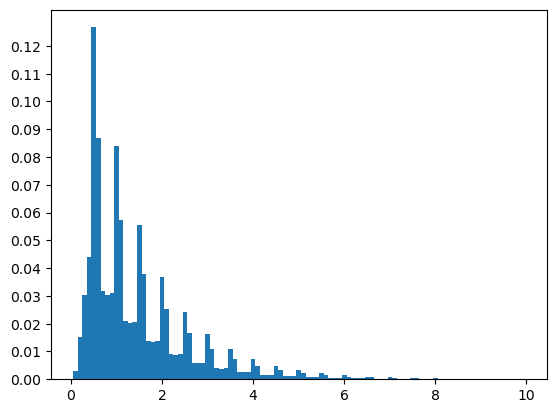

In [15]:
plt.bar(states, expected_occurrence, width = 0.1)
plt.yticks(np.arange(0, np.max(expected_occurrence), 0.01));

## Now let's recover the P from the expected occurrence values

In [59]:
measured_exp_occ = [0.1, 0, 0.3, 2.6, 13, 12.1, 1.6, 0.5, 2.7, 6.7, 6.2, 2, 0.4, 1.4, 2.7, 2.55, 1.1, 0.6, 1.4, 2.3, 2.1, 1.1, 0.5, 0.75, 1.1, 1.05, 0.65, 0.5, 0.8, 1.2, 1, 0.7, 0.4, 0.5, 0.6, 0.55, 0.45, 0.4, 0.6, 0.65, 0.6, 0.45, 0.3, 0.35, 0.4, 0.35, 0.3, 0.3, 0.35, 0.4]
expected_occurrence = [x/100 for x in measured_exp_occ]
states = np.arange(0.1, 5.1, 0.1)

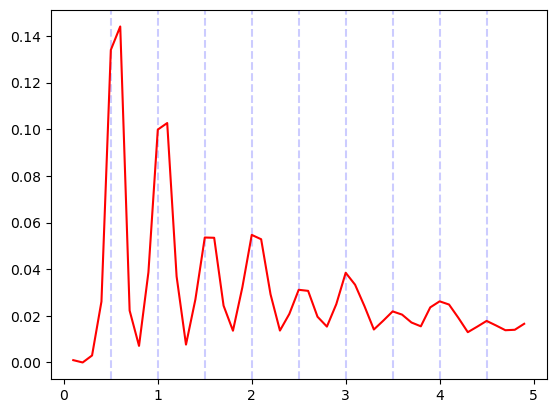

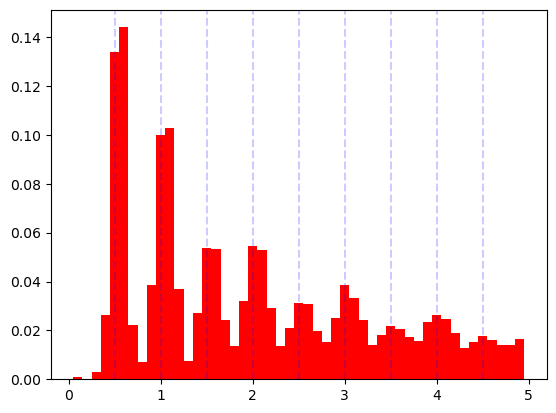

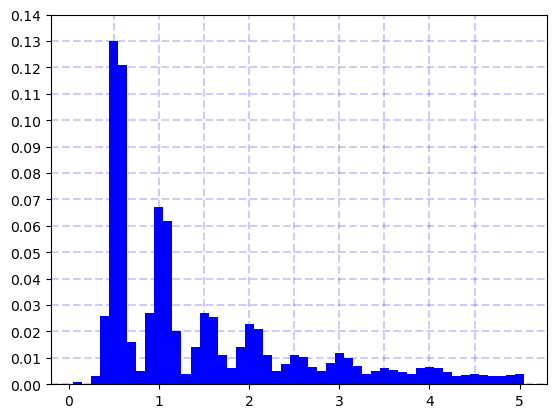

In [60]:
from decimal import Decimal, getcontext

myP = []
prod = []

for i in range(len(states)):
    if(i>0):
        prod = 1
        for j in range(i):
            prod *= (1 - myP[j])
            
        p = expected_occurrence[i]/prod
#         print(prod)
    else:
        p = expected_occurrence[i]/1
        
    myP.append(p)
    
plt.figure(1)
for i in range(5, 50, 5):
    plt.axvline(i/10, color='b', linestyle = '--', alpha = 0.2)
    
plt.plot(states[:-1], myP[:-1], color = 'r')

plt.figure(3)
for i in range(5, 50, 5):
    plt.axvline(i/10, color='b', linestyle = '--', alpha = 0.2)

plt.bar(states[:-1], myP[:-1], color = 'r', width = 0.1)

plt.figure(2)
for i in range(14):
    plt.axhline(i/100, color='b', linestyle = '--', alpha = 0.2)
for i in range(5, 50, 5):
    plt.axvline(i/10, color='b', linestyle = '--', alpha = 0.2)
    
plt.bar(states, expected_occurrence, width = 0.1, color = 'b')
plt.yticks(np.arange(0, np.max(expected_occurrence)+0.02, 0.01));

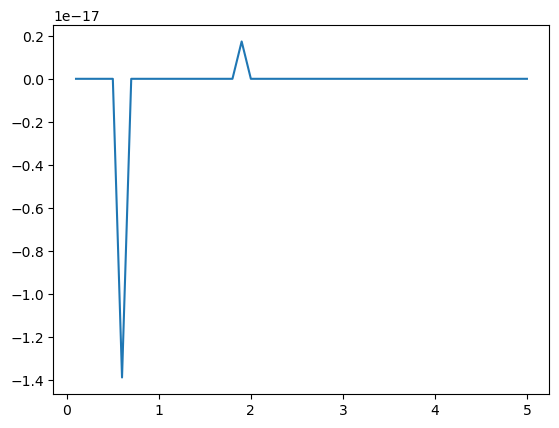

In [63]:
E = []

for i in range(len(myP)):
    if(i == 0):
        E.append(myP[i])
    else:
        prod = 1
        for j in range(i):
            prod *= (1-myP[j])
            
        E.append(myP[i] * prod)
        
diff = np.array(E) - np.array(expected_occurrence)

plt.plot(states, diff)

    
    

## Dirac's Delta Fcn

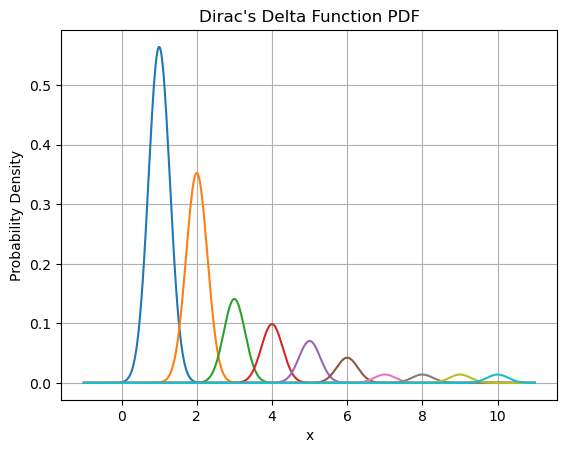

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def dirac_delta(x, x0, epsilon, scale):
    return scale * 1.0 / (epsilon * np.sqrt(np.pi)) * np.exp(-(x - x0)**2 / epsilon**2)

x = np.arange(-1.0, 11.0, 0.01)
pdf = []

scale = [0.4, 0.25, 0.10, 0.07, 0.05, 0.03, 0.01, 0.01, 0.01, 0.01]

for i in range(10):
    pdf.append(dirac_delta(x, i+1, 0.4, scale[i]))
    

for i in range(10):
    plt.plot(x, pdf[i])
    
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title("Dirac's Delta Function PDF")
plt.grid(True)
plt.show()

In [19]:
x = [x1, x2, x3, x4]
pdf = [pdf1, pdf2, pdf3, pdf4]
start = [0, 5, 10, 15]
mid = [5, 10, 15, 20]
end = [10, 15, 20, 25]

end_0 = np.where(x[0] <= 5)[0][-1]
x_total = []
pdf_total = []

x_total.extend(x[0][:end_0+1])
pdf_total.extend(pdf[0][:end_0+1])

for i in range(3):
    start_index = np.where(x[i] >= mid[i])[0][0]
    end_index = np.where(x[i] <= end[i])[0][-1]
    
    x_overlap = x[i][start_index: end_index + 1]
    pdf_overlap = pdf[i][start_index: end_index + 1] + pdf[i+1][: len(x_overlap)]
    
    x_total.extend(x_overlap)
    pdf_total.extend(pdf_overlap)

    
# start_1 = np.where(x[-1] >= mid[-1])[0][0]
# end_1 = np.where(x[-1] <= end[-1])[0][-1]

# x_total.extend(x[-1][start_1:end_1+1])
# pdf_total.extend(pdf[-1][start_1:end_1+1])

x_total = np.array(x_total)/10
pdf_total = np.array(pdf_total)/4

plt.plot(x_total, pdf_total)
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Sum of PDFs (Overlapping Range)')
plt.grid(True)
plt.show()


NameError: name 'x1' is not defined

In [ ]:
states_here = np.arange(0.0, 2.0, 0.1)
prob = []

eps = 0.001

for x in x_total:
    if(x%0.1 < eps):
        index = np.where(x_total == x)
        prob.append(pdf_total[index])
        
plt.plot(states_here, prob)    
plt.plot(states[:-1], myP[:-1], color = 'r')

## Gaussian Dist

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

pdf = []
x_total = []

for i in range(1, 11):
    # Parameters
    mean = i
    std_dev = 0.1

    # Define the range
    x = np.arange(0, 11.0, 0.01)

    # Calculate the probabilities using the Gaussian distribution formula
    probabilities = np.exp(-(x - mean)**2 / (2 * std_dev**2)) / (std_dev * np.sqrt(2 * np.pi))

    # Normalize the probabilities
    probabilities /= np.sum(probabilities)
    
    x_total.append(x)
    pdf.append(probabilities)

# Plot the discrete Gaussian distribution
for i in range(len(x_total)):
    plt.plot(x_total[i], pdf[i])
    plt.xlabel('Value')
    plt.ylabel('Probability')
    plt.title('Gaussian Distribution')

plt.show()


In [ ]:
pdf_cumulative = []

for i in range(len(pdf[0])):
    sum_of_pdfs = 0
    for j in range(len(pdf)):
        sum_of_pdfs += pdf[j][i]
        
    pdf_cumulative.append(sum_of_pdfs)
    
plt.plot(x, pdf_cumulative)

## Comm Delay Gauss Constant

In [ ]:
from scipy.stats import norm

mean = np.arange(1.0, 10.1, 1.0)

X = np.arange(0.1, 10.1, 0.1)

pdf_total = []

scale = 0.4

normalization = sum(norm.pdf(X, loc = mu, scale = scale))

for x in X:
    sum_pdf = 0
    for mu in mean:
        pdf = norm.pdf(X, loc = mu, scale = scale)
        pdf = pdf / np.sum(pdf) * (1/2*mu)
        sum_pdf += norm.pdf(x, loc = mu, scale = scale)/np.sum(pdf)
        
#         plt.plot(X, pdf)
        
    pdf_total.append(sum_pdf)
    
pdf_total = pdf_total/normalization
plt.plot(X, pdf_total)

def probability_distribution(t, pdf_total):
    pdf_values = []
    
    pdf_total[-1] = 1
    
    if(t is list):
        for value in t:
            index = int(value * 10) - 1
            pdf_value = pdf_total[index]
            pdf_values.append(pdf_value)
    else:
        index = int(t * 10) - 1
        pdf_values = pdf_total[index]

    return pdf_values

In [ ]:
# let's take the states from the previous simulations
states = np.arange(0.1, 10.1, 0.1)
n = len(states)
P = np.zeros((n, n))

# create the transition matrix

for i in range(len(states) - 1):
    P[i][0] = probability_distribution(states[i], pdf_total)
    P[i][i+1] = 1 - P[i][0]
    
P[n-1][0] = 1

In [ ]:
pi = np.array([0 for x in states])
pi[0] = 1

# to get the equilibrium states, instead of solving for pi*A = pi,
# we can do the operation for several times
nb_of_calc = 50

for i in range(nb_of_calc):
    pi = np.dot(pi, P)
    
# the expected occurrence of each sent data is the normalized probability of each state
expected_occurrence = np.array(pi * P[:, 0]/sum(pi * P[:, 0]))
# print(pi)
# print(expected_occurrence)

plt.figure(1)

plt.bar(states, expected_occurrence, color = 'r', label = "Markov Chain", width = 0.1)

for i in range(10):
    print(sum(expected_occurrence[states <= i+1]))
